In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Predicción de Ingresos de clientes de una Fintech

> El término préstamo se refiere a un tipo de operación financiera en la cual se presta una suma de dinero a otra parte a cambio de un reembolso futuro del valor o monto principal. En muchos caos, el prestamista también agrega intereses y/o cargos financieros al valor del principal que el prestatario debe pagar... Los préstamos vienen en muchas formas diferentes, incluyendo préstamos garantizados, no grantizados, comerciales yp ersonales (https://www.investopedia.com/terms/l/loan.asp)

Z. Zhang, "Research of Default Risk of Commercial Bank's Personal Loan Based on Rough Sets and Neural Network," 2011 3rd International Workshop on Intelligent Systems and Applications, 2011, pp. 1-4, doi: 10.1109/ISA.2011.5873366.


El surgimiento de las Fintechs ha sido disruptivo para el negocio tradicional de los préstamos. La automatización de procesos ha demostrado ser un ventaja competitiva, mostrando escalas de operabilidad sin precedentes. [bibliografía]

En su fortaleza también aparecen sus amenazas. Por momentos la promesa de automatización completa no puede ser satisfecha por los desafios técnicos que requiere y por otro lado por la presión de inversores y clientes se debe cumplir con la desburocratización de los procesos.

 Desde un punto de vista créditicio siguen haciendo frente a las preguntas fundamentales del riesgo tradicional

* ¿A quiénes prestarle dinero?
* ¿Cuánto dinero deberían prestarle?

La segunda pregunta será el foco de nuestro análisis, abordandola desde el punto de vista de la Capacidad de Pago

> Capacidad de Pago es entendido como la posibilidad o no de hacerle frente a un compromiso. Desde un punto de vista práctico representaría un ratio de liquidez dado por cuantas cuotas o mensualidad de un préstamo puede pagar el ingreso disponible de un cliente

En nuestro caso nos enfrentamos una Fintech con un año de antiguedad en el mercado que a partir de septiembre del 2021 buscará dejar de pedir comprobante a todos los clientes. Sin embargo posee una definición de capacidad de pago y un valor umbral, determinado por la siguiente ecuación.
$$
  \text{CAP true} = \frac{\text{Ingreso real} - 2000*Dependientes - Pagos a Bureau}{Mensualidad} >= 2
$$

Dada la baja voluntad en declarar sus ingresos verdaderos y en el objetivo de no pedir comprobantes, nos encontramos en un dilema.

Las propuestas para abordar el caso son dos:
* 1- El departamento de operaciones preocupado por la conversión sugiere utilizar el Score créditicio >= 680 cómo política para aceptar el ingreso declarado cómo real. La hipótesis es que los clientes con buen score créditicio buscan no perjudicar su historial.
* 2- El departamento de Machine Learning propone un modelo de ingresos que permita minimizar los riesgos sujeto a la cantidad de conversión de la propuesta anterior.


# Dataset


In [36]:
path = "../data/"
prospectos = pd.read_csv(path + "prospectos.csv", index_col=0)

In [40]:
prospectos.shape

(13147, 50)

Posemos un dataset con 13147 prospectos, es decir, clientes que presentaron su documentación de ingreso real y por distintas razones (ya sea que rechazaron el préstamo o fueron rechazados) no son parte actual de la cartera crediticia. Además posemos una cartera de 10mil clientes que fueron aprobados y si son parte de la cartera actual y la misma cantidad de clientes que fueron aprobados.

In [42]:
aprobados = pd.read_csv(path + "aprobados.csv", index_col=0, usecols = prospectos.columns)
aprobados.shape

(13943, 49)

La data pertenece a información recolectada del Bureau de Crédito de México sumado a dos columnas. Ingreso Declarado e Ingreso real. El declarado pertenece al input que se da en la página web y el ingreso real pertenece a los papeles presentados por el cliente e ingresados posteriormente por los operarios de los locales. [bibliografia: Manual técnico]

# Diccionario de variables


CLASIFICACIÓN DE PUNTUALIDAD DE PAGO - MOP (Manner of Payment – por sus siglas en inglés)
Contiene el código que indica si la cuenta está al corriente (sin atraso) o tiene atraso en sus pagos.
Los valores que pueden reportarse en este campo están indicados en el Anexo 3- Clasificación de puntualidad de pago-MOP, que se presenta en períodos de 30 días.
Ejemplos: si en Cliente tiene pagos mensuales y 1 pago atrasado MOP= 02. Si tiene pagos semanales: con 1 pago atrasado: MOP= 02; con 2 pagos atrasados: MOP= 02, con 3 pagos MOP= 02, etc.

Clasificación de Puntualidad de Pago – MOP
Las Claves de Clasificación de Puntualidad de Pago – MOP, indica el tiempo transcurrido desde que el Cliente
debió haber cumplido con el compromiso de pago acordado con el Usuario.
La siguiente tabla describe los códigos de Puntualidad de pago o MOP (Manner of Payment).

In [43]:
aprobados.columns

Index(['declarativa', 'fecha de apertura de la cuenta más antigua',
       'fecha de apertura de la cuenta más reciente',
       'fecha de la consulta mas reciente', 'mensaje de alerta',
       'moneda del credito', 'nueva direccion en los últimos 60 días',
       'número de cuentas', 'número de cuentas cerradas',
       'número de cuentas con historial de morosidad',
       'número de cuentas con mop = 00', 'número de cuentas con mop = 01',
       'número de cuentas con mop = 02', 'número de cuentas con mop = 03',
       'número de cuentas con mop = 04', 'número de cuentas con mop = 05',
       'número de cuentas con mop = 06', 'número de cuentas con mop = 07',
       'número de cuentas con mop = 96', 'número de cuentas con mop = 97',
       'número de cuentas con mop = 99', 'número de cuentas con mop = UR',
       'número de cuentas con morosidad actual',
       'número de cuentas de pagos fijos e hipotecarios',
       'número de cuentas en aclaración',
       'número de cuentas en d

In [52]:
df2 = pd.concat([aprobados, prospectos], ignore_index=True, sort=False)


$$
  Declaran = \frac{Declared Income - True Income}{True Income}
$$

In [53]:
cant_declaran_más= len(df2[df2.net_income_verified > df2.ingreso_neto_comprobado])
print(f"La cantidad de clientes que declaran más son {cant_declaran_más} y representan el {(cant_declaran_más/len(df2))*100:.2f}% del dataset")

La cantidad de clientes que declaran más son 6316 y representan el 23.31% del dataset


In [54]:
df2["diff_per"] = (df2["net_income_verified"] - df2["ingreso_neto_comprobado"])/df2["ingreso_neto_comprobado"]

In [55]:
df2.loc[df2["diff_per"] == 0,  'Declaran'] = "Lo Mismo"
df2.loc[(df2["diff_per"] < 0), 'Declaran'] = "Menos"
df2.loc[(df2["diff_per"] > 0) & (df2["diff_per"] <= 0.3), 'Declaran'] = "entre 1% y 30% más"
df2.loc[(df2["diff_per"] > 0.3) & (df2["diff_per"] <= 0.5), 'Declaran'] = "entre 31% y 50% más"
df2.loc[(df2["diff_per"] > 0.5) & (df2["diff_per"] < 1), 'Declaran'] = "entre 51% y 99% más"
df2.loc[(df2["diff_per"] >= 1) , 'Declaran'] = "Más del 100%"

In [56]:
reorderlist = ["Más del 100%","entre 51% y 99% más","entre 31% y 50% más","entre 1% y 30% más","Lo Mismo", "Menos"]

In [57]:
declararon = pd.merge(df2.Declaran.value_counts(),df2.Declaran.value_counts(normalize=True), right_index=True, left_index=True)
declararon.columns = ["Cantidad Clientes","Proporcion"]
declararon = declararon.reindex(reorderlist)
declararon.index.name = "Declaran"

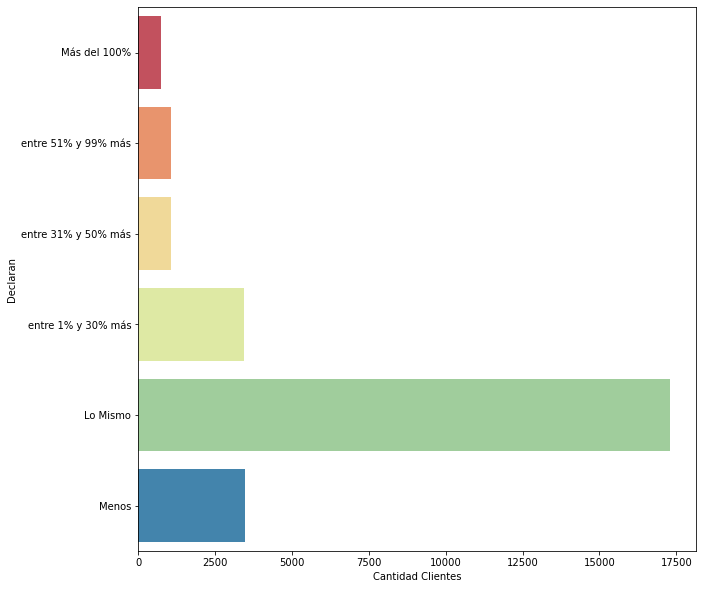

In [58]:
plt.figure(figsize=(10,10))
paleta = ["#d53e4f","#fc8d59", "#fee08b", "#e6f598", "#99d594", "#3288bd"]
sns.barplot(x="Cantidad Clientes",y=declararon.index,data=declararon, palette=paleta)
plt.savefig("cantidad.png", bbox_inches='tight')

In [59]:
declararon.loc['Total',:]= declararon.sum(axis=0)

per_problema = declararon[0:3]["Proporcion"].sum(axis=0)

declararon["Proporcion"] = (declararon["Proporcion"].round(2)*100).astype(str) + '%'
declararon["Cantidad Clientes"] = declararon["Cantidad Clientes"].astype(int)

In [60]:
total_problema = declararon[0:3]["Cantidad Clientes"].sum(axis=0)

print(f"El gran problema representa {total_problema} clientes \ny representa el {(per_problema*100):.2f}% de la población que \nconocemos el ingreso real \n")
declararon

El gran problema representa 2883 clientes 
y representa el 10.64% de la población que 
conocemos el ingreso real 



,Cantidad Clientes,Proporcion
Declaran,,
Más del 100%,741,3.0%
entre 51% y 99% más,1071,4.0%
entre 31% y 50% más,1071,4.0%
entre 1% y 30% más,3433,13.0%
Lo Mismo,17281,64.0%
Menos,3488,13.0%
Total,27085,100.0%


In [62]:
df2["ratio_income_min_w"] = df2["ingreso_neto_comprobado"]/4000

lst = [df2]
for column in lst:
    column.loc[column["ratio_income_min_w"] <= 1,  'salarios_min'] = " Hasta 1 salario min"
    column.loc[(column["ratio_income_min_w"] > 1) & (column["ratio_income_min_w"] <= 2), 'salarios_min'] = "1 hasta 2 salarios"
    column.loc[(column["ratio_income_min_w"] > 2) & (column["ratio_income_min_w"] <= 3), 'salarios_min'] = "2 hasta 3 salarios"
    column.loc[(column["ratio_income_min_w"] > 3) & (column["ratio_income_min_w"] <= 5), 'salarios_min'] = "3 hasta 5 salarios"
    column.loc[column["ratio_income_min_w"] >5, 'salarios_min'] = "+ de 5 salarios"

reorderlist = [" Hasta 1 salario min", "1 hasta 2 salarios","2 hasta 3 salarios","3 hasta 5 salarios", "+ de 5 salarios"]

,Cantidad Clientes Kavak,Proporcion Muestra,Mexico,% Poblacion Mexico
Ingreso Real,,,,
Hasta 1 salario min,0.0,0.0%,10642543,24.261%
1 hasta 2 salarios,139.0,0.5%,17141160,39.076%
2 hasta 3 salarios,2265.0,8.4%,9818858,22.383%
3 hasta 5 salarios,7726.0,28.5%,4522674,10.31%
+ de 5 salarios,16960.0,62.6%,1741491,3.97%
Total,27090.0,100.0%,43866726,100.0%


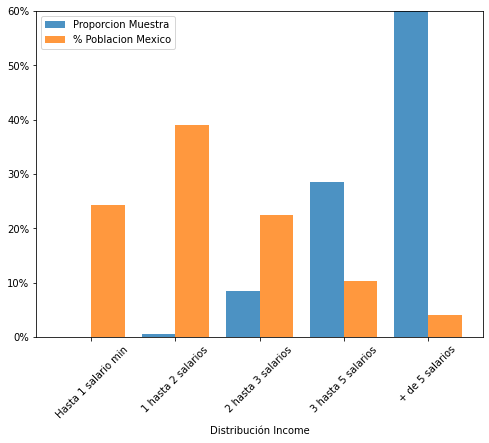

In [63]:
cantidad = df2.groupby(["salarios_min"]).agg(
    Cantidad =  ('salarios_min', 'count')).reindex(reorderlist)
proporcion = df2.salarios_min.value_counts(normalize=True).reindex(reorderlist).round(3)
inegi_df = pd.merge(cantidad,proporcion, right_index=True, left_index=True)
inegi_df.columns = ["Cantidad Clientes Kavak","Proporcion Muestra"]
inegi_df = inegi_df.reindex(reorderlist)
inegi_df.loc['Total',:]= inegi_df.sum(axis=0)
inegi_df.fillna(0, inplace=True)


inegi_df.index.name = "Ingreso Real"
inegi_df["Mexico"] = [10642543,17141160,9818858,4522674,1741491,43866726]
inegi_df["% Poblacion Mexico"] = [valor/43866726 for valor in inegi_df["Mexico"]]
inegi_plot = inegi_df.copy()
inegi_df["% Poblacion Mexico"] = ((inegi_df["% Poblacion Mexico"]*100).round(3)).astype(str) + '%'
inegi_df["Proporcion Muestra"] = ((inegi_df["Proporcion Muestra"]*100).round(2)).astype(str) + '%'
inegi_plot =inegi_plot.reset_index(level=0)
inegi_plot[0:5].plot(x="Ingreso Real",y=["Proporcion Muestra","% Poblacion Mexico"], kind="bar", width=0.8, alpha=0.8, align='center',figsize=(8,6)).set_ylim([0,0.6])
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in current_values])
plt.xticks(rotation=45)

plt.xlabel('Distribución Income')

inegi_df

In [64]:
df2.columns

Index(['declarativa', 'fecha de apertura de la cuenta más antigua',
       'fecha de apertura de la cuenta más reciente',
       'fecha de la consulta mas reciente', 'mensaje de alerta',
       'moneda del credito', 'nueva direccion en los últimos 60 días',
       'número de cuentas', 'número de cuentas cerradas',
       'número de cuentas con historial de morosidad',
       'número de cuentas con mop = 00', 'número de cuentas con mop = 01',
       'número de cuentas con mop = 02', 'número de cuentas con mop = 03',
       'número de cuentas con mop = 04', 'número de cuentas con mop = 05',
       'número de cuentas con mop = 06', 'número de cuentas con mop = 07',
       'número de cuentas con mop = 96', 'número de cuentas con mop = 97',
       'número de cuentas con mop = 99', 'número de cuentas con mop = UR',
       'número de cuentas con morosidad actual',
       'número de cuentas de pagos fijos e hipotecarios',
       'número de cuentas en aclaración',
       'número de cuentas en d

In [ ]:
cantidad = df2.groupby(["salarios_min"]).agg(
    Cantidad =  ('salarios_min', 'count')).reindex(reorderlist)
proporcion = df2.salarios_min.value_counts(normalize=True).reindex(reorderlist)

# Hipotesis negocio
# Ratios
# Regresion
# Ligthgbm